In [5]:
#Gather all outputs of processing step in one folder (All processed cases)
#Combining all cases
#output of this section (df) has been presented (in results folder)
import os
import pandas as pd
cwd = os.path.abspath("folder adress") #'C:\\....\\All processed cases'
files = os.listdir(cwd) 
os.chdir(r'folder adress')  #'C:\\....\\All processed cases'
df = pd.DataFrame()
for file in files:
     if file.endswith('.xlsx'):
        df = df.append(pd.read_excel(file), ignore_index=True) 
df.shape

(12000, 12)

In [6]:
#Adapting with ts_fresh package structure

df.sort_values(by = ['id','time'], inplace = True) #df excel is uploaded
df.drop("Unnamed: 0",axis = 1 , inplace = True)
df.fillna(method ="bfill",inplace=True)
df

,id,time,60sec_HKL,60sec_Torque,60sec_RPM,60sec_SPP,60sec_ROP,60sec_WOB,60sec_FR,inc,DLS
11280,1,0,320.250000,1978.333333,138.333333,2780.383333,3.400000,21.000000,275.483333,0.000000,0.000000
11281,1,1,320.233333,1890.000000,138.283333,2779.500000,3.400000,21.000000,275.216667,0.000000,0.000000
11282,1,2,320.000000,1990.000000,138.333333,2779.233333,3.400000,21.000000,275.000000,0.000000,0.000000
11283,1,3,319.516667,2030.000000,138.366667,2779.100000,3.400000,21.866667,275.000000,0.000000,0.000000
11284,1,4,320.016667,1940.000000,138.316667,2779.033333,3.400000,21.000000,275.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
115,100,115,261.750000,2720.609924,30.327501,2383.189941,2.990000,9.495000,212.340004,36.547378,1.294756
116,100,116,261.216667,2854.186609,30.466000,2374.844869,2.917000,9.927166,214.089337,36.548740,1.297479
117,100,117,262.000000,3365.870504,30.559999,2381.697709,2.884667,9.678000,211.320169,36.549250,1.298500
118,100,118,262.133333,2697.709424,30.578666,2375.825960,2.950000,9.448000,211.157994,36.549931,1.299861


In [7]:
#Applying ts_fresh package

from tsfresh import extract_features
extracted_features = extract_features(df, column_id="id", column_sort="time")

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.33s/it]


In [10]:
#building target dataframe(lables)
#y excel is uploaded
import numpy as np
s = pd.read_excel("file adress") #C:\\...\\y.xlsx'
ss = pd.Series(s["label"],index = np.arange(1,101))

In [11]:
from tsfresh import extract_relevant_features
features_filtered_direct = extract_relevant_features(df, ss,
                                                     column_id='id', column_sort='time')

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.15s/it]


In [12]:
# import different algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score , recall_score, roc_auc_score, make_scorer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [125]:
##############################  AdaBoost ###############################
import time
start = time.time()
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
AdaBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier() ,random_state=42)
params_grid = {'base_estimator__min_samples_leaf':[1,4,5,6],
               'n_estimators':[10,50,80,100],
              }


# To be used within GridSearch
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# To be used in outer CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Non_nested parameter search and scoring
clf = GridSearchCV(estimator=AdaBoost, param_grid=params_grid, cv=inner_cv)
clf.fit(features_filtered_direct, ss)
non_nested_score = clf.best_score_

# Pass the gridSearch estimator to cross_validate
# This will be your required 5 x 4 cvs
# 5 for outer cv and 4 for gridSearch's internal CV
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score,pos_label= 1),
           'recall' : make_scorer(recall_score,pos_label= 1), 
           'specifisity' : make_scorer(precision_score,pos_label= 0)}
nested_score = cross_validate (clf, X=features_filtered_direct, y=ss, cv=outer_cv,scoring= scoring)
df_score = pd.DataFrame(nested_score)
df_mean_score = pd.DataFrame(df_score.mean())
df_mean_score.drop(['fit_time','score_time'],axis = 0,inplace =True)
end = time.time()

print(end - start, "seconds")
print(df_mean_score)

37.276196241378784 seconds
                         0
test_accuracy     0.930000
test_precision    0.920000
test_recall       0.800000
test_specifisity  0.937304


In [122]:
##############################  KNN ###############################

import time
start = time.time()
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
KNN = KNeighborsClassifier()
params_grid = {'n_neighbors' : np.arange(1,10),
             'weights':['uniform', 'distance'],
             'algorithm':['auto', 'ball_tree','kd_tree','brute'],
             'p' : [1,2]}

# To be used within GridSearch
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# To be used in outer CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Non_nested parameter search and scoring
clf = GridSearchCV(estimator=KNN, param_grid=params_grid, cv=inner_cv)
clf.fit(features_filtered_direct, ss)
non_nested_score = clf.best_score_

# Pass the gridSearch estimator to cross_validate
# This will be your required 5 x 4 cvs
# 5 for outer cv and 4 for gridSearch's internal CV
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score,pos_label= 1),
           'recall' : make_scorer(recall_score,pos_label= 1), 
           'specifisity' : make_scorer(precision_score,pos_label= 0)}
nested_score = cross_validate (clf, X=features_filtered_direct, y=ss, cv=outer_cv,scoring= scoring)
df_score = pd.DataFrame(nested_score)
df_mean_score = pd.DataFrame(df_score.mean())
df_mean_score.drop(['fit_time','score_time'],axis = 0,inplace =True)
end = time.time()

print(end - start, "seconds")
print(df_mean_score)

26.168832302093506 seconds
                         0
test_accuracy     0.860000
test_precision    0.950000
test_recall       0.480000
test_specifisity  0.852503


In [123]:
##############################  DT ###############################

import time
start = time.time()
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
DT = DecisionTreeClassifier(random_state = 42)
params_grid = {'criterion':['gini','entropy'],
             'max_depth':np.arange(1,5),
             'max_features': ['auto', 'sqrt', 'log2'],
             'min_samples_split': [2,3,4,5,10],
             'min_samples_leaf':np.arange(1,5)}
# To be used within GridSearch
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# To be used in outer CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Non_nested parameter search and scoring
clf = GridSearchCV(estimator=DT, param_grid=params_grid, cv=inner_cv)
clf.fit(features_filtered_direct, ss)
non_nested_score = clf.best_score_

# Pass the gridSearch estimator to cross_validate
# This will be your required 5 x 4 cvs
# 5 for outer cv and 4 for gridSearch's internal CV
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score,pos_label= 1),
           'recall' : make_scorer(recall_score,pos_label= 1), 
           'specifisity' : make_scorer(precision_score,pos_label= 0)}
nested_score = cross_validate (clf, X=features_filtered_direct, y=ss, cv=outer_cv,scoring= scoring)
df_score = pd.DataFrame(nested_score)
df_mean_score = pd.DataFrame(df_score.mean())
df_mean_score.drop(['fit_time','score_time'],axis = 0,inplace =True)
end = time.time()

print(end - start, "seconds")
print(df_mean_score)

78.5510516166687 seconds
                         0
test_accuracy     0.850000
test_precision    0.742857
test_recall       0.600000
test_specifisity  0.882026


In [124]:
##############################  naive_bayes ###############################

import time
start = time.time()
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
gnb = GaussianNB()
params_grid = {'var_smoothing': np.logspace(0,-9, num=100)}


# To be used within GridSearch
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# To be used in outer CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Non_nested parameter search and scoring
clf = GridSearchCV(estimator=gnb, param_grid=params_grid, cv=inner_cv)
clf.fit(features_filtered_direct, ss)
non_nested_score = clf.best_score_

# Pass the gridSearch estimator to cross_validate
# This will be your required 5 x 4 cvs
# 5 for outer cv and 4 for gridSearch's internal CV
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score,pos_label= 1),
           'recall' : make_scorer(recall_score,pos_label= 1), 
           'specifisity' : make_scorer(precision_score,pos_label= 0)}
nested_score = cross_validate (clf, X=features_filtered_direct, y=ss, cv=outer_cv,scoring= scoring)
df_score = pd.DataFrame(nested_score)
df_mean_score = pd.DataFrame(df_score.mean())
df_mean_score.drop(['fit_time','score_time'],axis = 0,inplace =True)
end = time.time()

print(end - start, "seconds")
print(df_mean_score)

18.689151763916016 seconds
                         0
test_accuracy     0.850000
test_precision    0.900000
test_recall       0.440000
test_specifisity  0.844088


In [126]:
##############################  SVM ###############################

import time
start = time.time()
from sklearn.svm import SVC
svm = SVC(random_state=42)
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold

params_grid = {'kernel': ['rbf'],'C': [0.1, 1, 10, 100, 200, 300, 400, 500]}


# To be used within GridSearch
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# To be used in outer CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Non_nested parameter search and scoring
clf = GridSearchCV(estimator=svm, param_grid=params_grid, cv=inner_cv)
clf.fit(features_filtered_direct, ss)
non_nested_score = clf.best_score_

# Pass the gridSearch estimator to cross_validate
# This will be your required 5 x 4 cvs
# 5 for outer cv and 4 for gridSearch's internal CV
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score,pos_label= 1),
           'recall' : make_scorer(recall_score,pos_label= 1), 
           'specifisity' : make_scorer(precision_score,pos_label= 0)}
nested_score = cross_validate (clf, X=features_filtered_direct, y=ss, cv=outer_cv,scoring= scoring)
df_score = pd.DataFrame(nested_score)
df_mean_score = pd.DataFrame(df_score.mean())
df_mean_score.drop(['fit_time','score_time'],axis = 0,inplace =True)
end = time.time()

print(end - start, "seconds")
print(df_mean_score)

1.4979612827301025 seconds
                         0
test_accuracy     0.860000
test_precision    0.802857
test_recall       0.600000
test_specifisity  0.885359


In [135]:
##############################  MLPClassifier ###############################

import time
start = time.time()
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=42)

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold

params_grid = {'hidden_layer_sizes' : [(1,1,1),(10,10,10),(20,20,20),(30,30,30),(40,40,40),(50,50,50)]
              ,'solver': ['adam','lbfgs']  #,(5,5,5),(15,15,15),(45,45,45),(60,60,60)
              ,'alpha': [0.0001, 0.05]}
# To be used within GridSearch
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# To be used in outer CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Non_nested parameter search and scoring
clf = GridSearchCV(estimator= mlp, param_grid =params_grid, cv=inner_cv)
clf.fit(features_filtered_direct, ss)
non_nested_score = clf.best_score_

# Pass the gridSearch estimator to cross_validate
# This will be your required 5 x 4 cvs
# 5 for outer cv and 4 for gridSearch's internal CV
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score,pos_label= 1),
           'recall' : make_scorer(recall_score,pos_label= 1), 
           'specifisity' : make_scorer(precision_score,pos_label= 0)}
nested_score = cross_validate (clf, X=features_filtered_direct, y=ss, cv=outer_cv,scoring= scoring)
df_score = pd.DataFrame(nested_score)
df_mean_score = pd.DataFrame(df_score.mean())
df_mean_score.drop(['fit_time','score_time'],axis = 0,inplace =True)
end = time.time()

print(end - start, "seconds")
print(df_mean_score)

42.69795227050781 seconds
                         0
test_accuracy     0.850000
test_precision    0.712857
test_recall       0.680000
test_specifisity  0.898333


In [140]:
##############################  BaggingClassifier ###############################

import time
start = time.time()
from sklearn.ensemble import BaggingClassifier
Bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)


from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold

params_grid = {'base_estimator__min_samples_leaf':[1,4,5,6],
               'n_estimators':[10,50,80,100],
                 'bootstrap_features': [True, False]}

# To be used within GridSearch
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# To be used in outer CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Non_nested parameter search and scoring
clf = GridSearchCV(estimator= Bagging, param_grid =params_grid, cv=inner_cv)
clf.fit(features_filtered_direct, ss)
non_nested_score = clf.best_score_

# Pass the gridSearch estimator to cross_validate
# This will be your required 5 x 4 cvs
# 5 for outer cv and 4 for gridSearch's internal CV
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score,pos_label= 1),
           'recall' : make_scorer(recall_score,pos_label= 1), 
           'specifisity' : make_scorer(precision_score,pos_label= 0)}
nested_score = cross_validate (clf, X=features_filtered_direct, y=ss, cv=outer_cv,scoring= scoring)
df_score = pd.DataFrame(nested_score)
df_mean_score = pd.DataFrame(df_score.mean())
df_mean_score.drop(['fit_time','score_time'],axis = 0,inplace =True)
end = time.time()

print(end - start, "seconds")
print(df_mean_score)

118.71057319641113 seconds
                         0
test_accuracy     0.880000
test_precision    0.883333
test_recall       0.640000
test_specifisity  0.890126


In [150]:
##############################  GradientBoostingClassifier ###############################

import time
start = time.time()
from sklearn.ensemble import GradientBoostingClassifier
GBM = GradientBoostingClassifier(random_state=42)

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold

params_grid = {'n_estimators':[10,50,80,100],
               'max_depth':[1,2,3],
               'max_features': ['auto', 'sqrt', 'log2']
               #'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]
                }
# To be used within GridSearch
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# To be used in outer CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Non_nested parameter search and scoring
clf = GridSearchCV(estimator= GBM, param_grid =params_grid, cv=inner_cv)
clf.fit(features_filtered_direct, ss)
non_nested_score = clf.best_score_

# Pass the gridSearch estimator to cross_validate
# This will be your required 5 x 4 cvs
# 5 for outer cv and 4 for gridSearch's internal CV
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score,pos_label= 1),
           'recall' : make_scorer(recall_score,pos_label= 1), 
           'specifisity' : make_scorer(precision_score,pos_label= 0)}
nested_score = cross_validate (clf, X=features_filtered_direct, y=ss, cv=outer_cv,scoring= scoring)
df_score = pd.DataFrame(nested_score)
df_mean_score = pd.DataFrame(df_score.mean())
df_mean_score.drop(['fit_time','score_time'],axis = 0,inplace =True)
end = time.time()

print(end - start, "seconds")
print(df_mean_score)

45.201878786087036 seconds
                         0
test_accuracy     0.890000
test_precision    0.950000
test_recall       0.600000
test_specifisity  0.884365


In [156]:
##############################  RandomForestClassifier ###############################


import time
start = time.time()
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold

params_grid = {'n_estimators': [10,50,80,100],
              'min_samples_leaf':[1,2,3,4,6],
              'max_depth': [1,2,3]
              }
# To be used within GridSearch
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# To be used in outer CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Non_nested parameter search and scoring
clf = GridSearchCV(estimator= rf, param_grid =params_grid, cv=inner_cv)
clf.fit(features_filtered_direct, ss)
non_nested_score = clf.best_score_

# Pass the gridSearch estimator to cross_validate
# This will be your required 5 x 4 cvs
# 5 for outer cv and 4 for gridSearch's internal CV
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score,pos_label= 1),
           'recall' : make_scorer(recall_score,pos_label= 1), 
           'specifisity' : make_scorer(precision_score,pos_label= 0)}
nested_score = cross_validate (clf, X=features_filtered_direct, y=ss, cv=outer_cv,scoring= scoring)
df_score = pd.DataFrame(nested_score)
df_mean_score = pd.DataFrame(df_score.mean())
df_mean_score.drop(['fit_time','score_time'],axis = 0,inplace =True)
end = time.time()

print(end - start, "seconds")
print(df_mean_score)

171.60305619239807 seconds
                         0
test_accuracy     0.880000
test_precision    0.883333
test_recall       0.640000
test_specifisity  0.890126


In [163]:
##############################  ExtraTreesClassifier ###############################

import time
start = time.time()
from sklearn.ensemble import ExtraTreesClassifier
extc = ExtraTreesClassifier(random_state=42)

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold

params_grid = {'n_estimators': [10,50,80,100],
               'min_samples_leaf':[1,2,3,4,6],
              }
# To be used within GridSearch
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# To be used in outer CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Non_nested parameter search and scoring
clf = GridSearchCV(estimator= extc, param_grid =params_grid, cv=inner_cv)
clf.fit(features_filtered_direct, ss)
non_nested_score = clf.best_score_

# Pass the gridSearch estimator to cross_validate
# This will be your required 5 x 4 cvs
# 5 for outer cv and 4 for gridSearch's internal CV
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score,pos_label= 1),
           'recall' : make_scorer(recall_score,pos_label= 1), 
           'specifisity' : make_scorer(precision_score,pos_label= 0)}
nested_score = cross_validate (clf, X=features_filtered_direct, y=ss, cv=outer_cv,scoring= scoring)
df_score = pd.DataFrame(nested_score)
df_mean_score = pd.DataFrame(df_score.mean())
df_mean_score.drop(['fit_time','score_time'],axis = 0,inplace =True)
end = time.time()

print(end - start, "seconds")
print(df_mean_score)

46.91383194923401 seconds
                         0
test_accuracy     0.880000
test_precision    0.910000
test_recall       0.600000
test_specifisity  0.881275


In [164]:
##############################  XGBClassifier ###############################

import time
start = time.time()
from xgboost.sklearn import XGBClassifier
xgb = XGBClassifier(use_label_encoder=False,eval_metric='mlogloss',random_state=42)


from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold

params_grid = {'max_depth': [1,2,4],
               'n_estimators': [1,2,3,4,5,6,7]
               }
# To be used within GridSearch
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# To be used in outer CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Non_nested parameter search and scoring
clf = GridSearchCV(estimator= xgb, param_grid =params_grid, cv=inner_cv)
clf.fit(features_filtered_direct, ss)
non_nested_score = clf.best_score_

# Pass the gridSearch estimator to cross_validate
# This will be your required 5 x 4 cvs
# 5 for outer cv and 4 for gridSearch's internal CV
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score,pos_label= 1),
           'recall' : make_scorer(recall_score,pos_label= 1), 
           'specifisity' : make_scorer(precision_score,pos_label= 0)}
nested_score = cross_validate (clf, X=features_filtered_direct, y=ss, cv=outer_cv,scoring= scoring)
df_score = pd.DataFrame(nested_score)
df_mean_score = pd.DataFrame(df_score.mean())
df_mean_score.drop(['fit_time','score_time'],axis = 0,inplace =True)
end = time.time()

print(end - start, "seconds")
print(df_mean_score)

16.176957368850708 seconds
                         0
test_accuracy     0.880000
test_precision    0.813333
test_recall       0.720000
test_specifisity  0.909685


In [169]:
##############################  LogisticRegression ###############################

import time
start = time.time()
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()


import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
    
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold

params_grid = {'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
               'penalty' : ['l2'],
               'C' : [10,1.0, 0.1, 0.01]}
# To be used within GridSearch
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# To be used in outer CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Non_nested parameter search and scoring
clf = GridSearchCV(estimator= lgr, param_grid =params_grid, cv=inner_cv)
clf.fit(features_filtered_direct, ss)
non_nested_score = clf.best_score_

# Pass the gridSearch estimator to cross_validate
# This will be your required 5 x 4 cvs
# 5 for outer cv and 4 for gridSearch's internal CV
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score,pos_label= 1),
           'recall' : make_scorer(recall_score,pos_label= 1), 
           'specifisity' : make_scorer(precision_score,pos_label= 0)}
nested_score = cross_validate (clf, X=features_filtered_direct, y=ss, cv=outer_cv,scoring= scoring)
df_score = pd.DataFrame(nested_score)
df_mean_score = pd.DataFrame(df_score.mean())
df_mean_score.drop(['fit_time','score_time'],axis = 0,inplace =True)
end = time.time()

print(end - start, "seconds")
print(df_mean_score)

21.167930364608765 seconds
                         0
test_accuracy     0.820000
test_precision    0.655952
test_recall       0.640000
test_specifisity  0.889027


In [170]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features_filtered_direct, ss, test_size = 0.3, random_state=0,stratify=ss)

In [171]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
AdaBoost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier() ,random_state=42 )
params_grid = {'base_estimator__max_depth':np.arange(1,6),
               'base_estimator__criterion':['entropy','gini'],
               'base_estimator__max_features': [None,'auto', 'sqrt', 'log2'],
               'base_estimator__min_samples_leaf':[1,2,3,4,5],
               'n_estimators':[5,10,20,50,80,88,90,100],
               'learning_rate':[0.01,0.1,1]
               }

scoring = {'Accuracy': make_scorer(accuracy_score)}
grid = GridSearchCV(AdaBoost, params_grid, cv=4 , scoring = scoring,refit='Accuracy')
grid.fit(x_train,y_train)
print(grid.best_params_, grid.best_score_ )

{'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 3, 'base_estimator__max_features': 'log2', 'base_estimator__min_samples_leaf': 1, 'learning_rate': 1, 'n_estimators': 50} 0.9428104575163399


Automatically created module for IPython interactive environment
Confusion matrix
[[23  0]
 [ 2  5]]
Normalized confusion matrix
[[1.         0.        ]
 [0.28571429 0.71428571]]


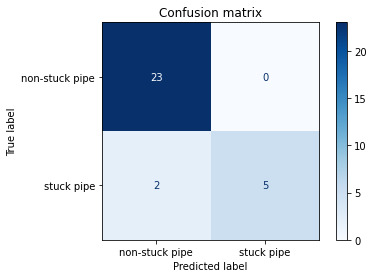

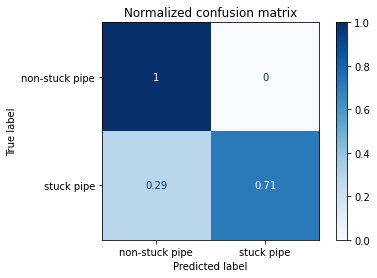

In [172]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
class_names = [ 'non-stuck pipe','stuck pipe']

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion ='gini',max_depth = 3
                                   ,max_features = 'log2', min_samples_leaf= 1), learning_rate = 1,n_estimators = 50
                                ,random_state=42 ).fit(x_train, y_train)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()